# Classification Trees in Python, From Start to Finish

## Link do videa: https://www.youtube.com/watch?v=q90UDEgYqeI
In this lesson we will use scikit-learn and Cost Complexity Pruning to build this Classification Tree (below), which uses continuous and categorical data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php) to predict whether or not patient has heart disease:  

<img src ="dt.png" style="display: block; margin: auto"/>

**Classification Trees** are an exceptionally useful machine learning method when you need to know how the decisions are being made. For example, if you have to justify the predictions to your boss, **Classification** Tress are a good method because each step in the decision making process is easy to understand. 

In this lesson you will learn about:

* Importing Data
* Missing Data
    * Identifying Missing Data
    * Dealing with Missing Data
* Formatting the Data for Decision Trees
    * Splitting data into Dependent and Independent Variables
    * One-Hot-Encoding
* Building a Preliminary Classification Tree
* Optimizing the tree with Cost Complexity Pruning
    * Visualizing Alpha
    * Using Cross Validation to find the best values for Alpha
* Building, Drawing, Interpreting and Evaluating the Final Classification Tree

### NOTE: 
Keywords are: ***Classification Trees***, ***Cost Complexity Pruning***, ***Cross Validation***, ***Confusion Matrices*** and ***Bias and Variance***
***


# Import the modules that will do all the work 

The very first thing we do is load in a bunch of python modules. Python, itself, just gives us a basic programming language. These modules give us extra functionality to import the data, clean it up and format it, and then build, evaluate and draw the classification tree.

***NOTE***: You will need Python 3 and these following modules:

* pandas
* numpy 
* sklearn

In [2]:
import pandas as pd # to load and manipulate data and for One-Hot Encoding 
import numpy as np # to calculate the mean and standard deviation 
import matplotlib.pyplot as plt # to draw graphs 
from sklearn.tree import DecisionTreeClassifier # to build a classification tree
from sklearn.tree import plot_tree # to draw a classification tree
from sklearn.model_selection import train_test_split # to split data into training and testing datasets
from sklearn.model_selection import cross_val_score # for cross validation
from sklearn.metrics import confusion_matrix # to create a confusion matrix 
from sklearn.metrics import plot_confusion_matrix # to draw a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

***

# Import the data

Now we load in a dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php). Specifically, we are going to use the Heart Disease Dataset. This dataset will allow us to predict if someone has heart disease based on their sex, age, blood pressure and a variety of other metrics.

***NOTE:*** When ***pandas (pd)*** reads in data, it returns ***dataframe***, which is a lot like spreadsheet. The data are organized in rows and columns and each row can contain a mixture of text and numbers. The standard variable name for a ***dataframe*** is the initials ***df***, and that is what we will use here:

In [3]:
## since we have already downloaded the data to a file, we can load the file...

df = pd.read_csv('processed.cleveland.data', header = None)

Now that we have loaded the data into a ***dataframe*** called ***df***, let's look at the first five rows using the head() function:

In [4]:
## print the first 5 rows 
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


We see that instead of nice column names, we just have column numbers. Since nice column names would make it easier to know how to format the data, let's replace the column numbers with the following column names:
* ***age***
* ***sex***
* ***cp***, chest pain
* ***restbp***, resting blood pressure (in mm Hg)
* ***chol***, serum cholesterol in mg/dl
* ***fbs***, fasting blood sugar
* ***restecg***, resting electrocardiographic results
* ***thalach***, maximum heart rate achieved
* ***exang***, exercise induced angina
* ***oldpeak***, ST depression induced by exercise relative to rest
* ***slope***, the slope of the peak exercise ST segment
* ***ca***, number of major vessels (0-3) colored by fluoroscopy
* ***thal***, this is short of thalium heart scan
* ***hd***, diagnosis of heart disease, the predicted attribute

In [5]:
## change the column numbers to column names
df.columns = ['age','sex','cp','restbp','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','hd']

## print the firs 5 rows (including the column names)
df.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


***

# Missing Data Part 1: Identifying Missing Data

Unfortunately, the biggest part of any data analysis project is making sure that the data is correctly formatted and fixing it when it is not. The first part of this process is identifying and dealing with ***Missing Data***.

***Missing Data*** is simply a blank space, or a surrogate value like ***NA***, that indicates that we failed to collect data for one of the features. For example, if we forgot to ask someone's age, or forgot to write it down, then we would have a blank space in the dataset for the person's ***age***.

There are two main ways to deal with missing data:

1. We can remove the rows that contain missing data from the dataset. This is relatively easy to do, but it wastes all of the other values that we collected. How a big of a waste this is depends on how important this missing value is for classification. For example, if we are missing a value for ***age***, and ***age*** is not useful for classifying if people have heart disease or not, then it would be a shame to throw out someone's data just because we do not have their ***age***.

2. We can ***impute*** the values that are missing. In this context ***impute*** is just a fancy way of saying "we can make an educated guess about what the value should be". Continuing our example where we are missing a value for ***age***, instead of throwing out the entire row of data, we can fill the missing value with the average age or the median age, or use some other, more sophisticated approach, to guess at an appropriate value.

In this section, we'll focus on identifying missing values in the dataset.

First, let's see what sort of data is in each column.

In [6]:
## dtypes tell us the "data type" for each column
df.dtypes

age        float64
sex        float64
cp         float64
restbp     float64
chol       float64
fbs        float64
restecg    float64
thalach    float64
exang      float64
oldpeak    float64
slope      float64
ca          object
thal        object
hd           int64
dtype: object

Wee see that they are almost all ***float64***, however, two columns, ***ca*** and ***thal***, have the ***object*** type and one column, ***hd*** has ***int64***.

The fact that the ***ca*** and ***thal*** columns have ***object*** data types suggests there is something funny going on in them. ***Object*** datatypes are used when there are mixture of things, like a mixture of numbers and letters. In theory, both ***ca*** and ***thal*** should just have few values representing different categories, so let's investigate what's going on by printing out their unique values. We'll start with ***ca***:

In [7]:
## print out unique values in the column called 'ca'
df['ca'].unique()

array(['0.0', '3.0', '2.0', '1.0', '?'], dtype=object)

We see that ***ca*** contains numbers (0.0, 3.0, 2.0, and 1.0) and questions marks (?). The numbers represent the number of blood vessels that we lit up by fluoroscopy and the question marks represent missing data.

Now let's look at the unique values in ***thal***.

In [8]:
## print out unique values in the column called 'thal'
df['thal'].unique()

array(['6.0', '3.0', '7.0', '?'], dtype=object)

Again, ***thal*** also contains a mixture of numbers, representing the different diagnoses from the thalium heart scan, and question marks, which represent missing values.

***

# Missing Data Part 2: Dealing With Missing Data

Since scikit-learn's classification trees do not support datasets with missing values, we need to figure out what to do with these question marks. We can either delete these patients from the training dataset, or impute values for the missing data. First let's see how many rows contain missing values.

In [9]:
## print the number of rows that contain missing values.
## 
## loc[], short for 'location', let's us specify which rows we want...
## and so we say we want any row with '?' in column 'ca'
## or 
## any row with '?' in column 'thal'
## 
## len(), short for 'length', prints out the number of rows.
len(df.loc[(df['ca'] == '?') | (df['thal'] == '?')])

6

In [10]:
## print out the rows that contain missing values
df.loc[(df['ca'] == '?') | (df['thal'] == '?')]

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,2
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


Now let's count the number o rows in the full dataset. 

In [11]:
len(df)

303

So ***6*** rows of the ***303*** rows, or ***2%***, contain missing values. Since ***303 - 6 = 297***, and ***297*** is plenty of data to build a classification tree, we will remove the rows with missing values, rather than try to impute their values. 

In [12]:
## use loc[] to select all rows that do not contain missing values
## and save them in a new dataframe called "df_no_missing"
df_no_missing = df.loc[(df['ca'] != '?') & (df['thal'] != '?')]

***

# Format Data Part 1: Split the Data into Dependent and Independent Variables

Now that we have taken care of the missing data, we are ready to start formatting the data for making a ***Classification Tree***.

The first step is to split the data into two parts:

1. The columns of data that we will use to make classifications 
2. The column of data that we want to predict.

We will use the conventional notation of ***X*** (capital ***X***) to represent the columns of data that we will use to make classifications and ***y*** (lower case ***y***) to represent the thing we want to predict. In this case, we want to predict ***hd*** (heart disease).

***NOTE:*** The reason we deal with missing data before splitting it into ***X*** and ***y*** is that we need to remove rows, splitting after ensures that each row in ***X*** correctly corresponds with the appropriate value in ***y***. 

***ALSO NOTE:*** In the code below we are using ***copy()*** to copy the data by value. By default, pandas uses copy by reference. Using ***copy()*** ensures that the original data ***df_no_missing*** is not modified when we modify ***X*** or ***y***. In other words, if we make a mistake when we are formatting the columns for classification trees, we can just re-copy ***df_no_missing***, rather than reload the original data and remove the missing values etc.

In [13]:
## Make a new copy of the columns used to make predictions 
X = df_no_missing.drop('hd', axis = 1).copy()
X.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0


In [14]:
## Make a new copy of the column of data we want to predict
y = df_no_missing['hd'].copy()
y.head()

0    0
1    2
2    1
3    0
4    0
Name: hd, dtype: int64

***

# Format the Data Part 2: One-Hot Encoding

Now that we have split the dataframe into two pieces, ***X***, which contains the data we will use to predict classifications, and ***y***, which contains the known classifications in our training dataset, we need to take a closer look at the variable ***X***. The list bellow tells us what each variable represents and the type of data (***float*** or ***categorical***) it should countain:

* ***age, Float***
* ***sex, Category***
    * 0 = female
    * 1 = male
* ***cp, Category***
    * 1 = typical angina
    * 2 = atypical angina
    * 3 = non-anginal pain 
    * 4 = asymptomatic
* ***restbp, Float***
* ***chol, Float***
* ***fbs, Category***
    * 0 = >= 120 mg/dl
    * 1 = <120 mg/dl
* ***restecg, Category***
    * 1 = normal
    * 2 = having ST-T wave abnormality
    * 3 = showing probable or definite left ventricular hypertrophy
* ***thalach, Float***
* ***exang, Category***
    * 0 = no
    * 1 = yes
* ***oldpeak, Float***
* ***slope, Category***
    * 1 = upsloping
    * 2 = flat
    * 3 = downsloping
* ***ca, Float***
* ***thal, Category***
    * 3 = normal
    * 6 = fixed defect
    * 7 = reversible defect

Now, just to review, let's look at the data types in ***X*** to remember how python is seeing the data right now.

In [15]:
X.dtypes

age        float64
sex        float64
cp         float64
restbp     float64
chol       float64
fbs        float64
restecg    float64
thalach    float64
exang      float64
oldpeak    float64
slope      float64
ca          object
thal        object
dtype: object

So, we see that ***age, restbp, chol*** and ***thalach*** are all ***float64***, which is good, because we want them to be floating point numbers. All of the other columns, however, need to be inspected to make sure they only contain reasonable values, and some of them need to change. This is because, while ***scikit learn Decision Trees*** natively support continuous data, like resting blood pressure (***restbp***) and maximum heart rate (***thalach***), they do not natively support categorical data, like chest pain (***cp***), which contains 4 different categories. Thus, in order to use categorical data with ***scikit learn Decision Trees***, we have to use a trick that converts a column of categorical data into multiple columns of binary values. This trick is called ***One-Hot Encoding***. 

At this point you may be wondering, "what's wrong with treating categorical data like continuous data?" To answer that question, let's look at an example:
For the ***cp*** (chest pain) column, we have 4 options:

1. typical angina
2. atypical angina
3. non-anginal pain
4. asymptomatic

If we treated these values 1, 2, 3 and 4 like continuous data, then we would assume that 4, which means "asymptomatic", is more similar to 3, which means "non-anginal pain", than it is to 1 or 2, which are other types of chest pain. That means the decision tree would be more likely to cluster the patients with 4s and 3s together than the patients with 4s and 1s together. In contrast, if we treat these numbers like categorical data, then we treat each one as a separate category that is no more or less similar to any of other categories. Thus, the likelihood of clustering patients with 4s and 3s is the same as clustering 4s with 1s, and that approach is more reasonable. 

Now let's inspect and, if needed, convert the columns that contain categorical and integer data into the correct datatypes. We'll start with ***cp*** (chest pain) by inspecting all of its unique values:

In [16]:
X['cp'].unique()

array([1., 4., 3., 2.])

So, the good news is that ***cp*** only contains the values it is supposed to contain, so we will convert it, using ***One-Hot Encoding***, into a series of columns that only contains ***0s*** and ***1s***. 

***NOTE:*** There are many different ways to do ***One-Hot Encoding*** in Python. Two of the more popular methods are ***ColumnTransformer()*** (from ***scikit-learn***) and ***get_dummies()*** (from ***pandas***), and the both methods have prons and cons. ***ColumnTransformer()*** has a very cool feature where it creates a persistent function that can validate data that you get in the future. For example, if you build your ***Decision Tree*** using a categorical variable ***favorite color*** that has ***red, blue*** and ***green*** options, then ***ColumnTransformer()*** can remember those options and later on when your ***Decision Tree*** is being used in a production system, if someone says their favorite color is ***orange***, then ***ColumnTransformer()*** can throw an error or handle the situation in some other nice way. The downside of ***ColumnTransformer()*** is that it turns your data into an array and looses all of the column names, making it harder to verify that your usage of ***ColumnTransformer()*** worked as you intended it to. In contrast, ***get_dummies()*** leaves your data in a dataframe and retains the column names, making it much easier to verify that it worked as intended. However, it does not have the persistent behaviour that ***ColumnTransformer()*** has. So, for the sake of learning how ***One-Hot Encoding*** works, I prefer to use ***get_dummies()***.

First, before we commit to converting ***cp*** with ***One-Hot Encoding***, let's just see what happens when we convert ***cp*** without saving the results. This will make it easy to see how ***get_dummies()*** works. 

In [17]:
## For this tutorial, we will use get_dummies() to do One-Hot Encoding,
## but just know that there are other options.
pd.get_dummies(X, columns = ['cp']).head()

,age,sex,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,cp_1.0,cp_2.0,cp_3.0,cp_4.0
0,63.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,1,0,0,0
1,67.0,1.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,0,0,0,1
2,67.0,1.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,0,0,0,1
3,37.0,1.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,1,0
4,41.0,0.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,1,0,0


As we can see in the printout above, ***get_dummies()*** puts all of the columns it does not process in the front and it puts ***cp*** at the end. It also splits ***cp*** into ***4*** columns, just like we expected it. ***cp_1.0*** is ***1*** for any patient that scored a ***1*** for chest pain and ***0*** for all other patients. ***cp_2.0*** is ***1*** for any patient that scored ***2*** for chest pain and ***0*** for all other patients. ***cp_3.0*** is ***1*** for any patient that scored ***3*** for chest pain and ***cp_4.0*** is ***1*** for any patient that scored ***4*** for chest pain.

Now that we see how ***get_dummies()*** works, let's use it on the four categorical columns that have more than 2 categories and save the result. 

In [18]:
X_encoded = pd.get_dummies(X, columns = ['cp', 'restecg', 'slope', 'thal'])
X_encoded.head()

,age,sex,restbp,chol,fbs,thalach,exang,oldpeak,ca,cp_1.0,...,cp_4.0,restecg_0.0,restecg_1.0,restecg_2.0,slope_1.0,slope_2.0,slope_3.0,thal_3.0,thal_6.0,thal_7.0
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0.0,1,...,0,0,0,1,0,0,1,0,1,0
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,3.0,0,...,1,0,0,1,0,1,0,1,0,0
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,0,...,1,0,0,1,0,1,0,0,0,1
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0.0,0,...,0,1,0,0,0,0,1,1,0,0
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0.0,0,...,0,0,0,1,1,0,0,1,0,0


Now we need to talk about the ***3*** categorical columns that only contain ***0s*** and ***1s***: ***sex, fbs*** and ***exang***. As we can see, ***One-Hot Encoding*** converts a column with more than ***2*** categories into mulltiple columns of ***0s*** and ***1s***. Since ***sex, fbs*** and ***exang*** only have ***2*** categories and only contain ***0s*** and ***1s*** to begin with, we do not have to do anything special to them, so we're done formatting the data for the ***Classification Tree***.

***NOTE:*** In practice we would use ***unique()*** to verify that they only contain ***0s*** and ***1s***...

Now, one last thing before we build a ***Classification Tree***. ***y*** doesn't just contain ***0s*** and ***1s***. Instead, it has ***5*** different levels of heart disease. ***0***=no heart disease and ***1-4*** are various degrees of heart disease. We can see this with ***unique()***:

In [19]:
y.unique()

array([0, 2, 1, 3, 4], dtype=int64)

In this tutorial we're only making a tree that does simple classification and only care if someone has heart disease or not, so we need to convert all numbers ***>0*** to ***1***.

In [20]:
y_not_zero_index = y > 0 # get index for each non-zero value in y 
y[y_not_zero_index] = 1 # set each non-zero value in y to 1
y.unique() # verify that y only contains 0 and 1

array([0, 1], dtype=int64)

***

# Build A Preliminary Classification Tree

At long last, the data are correctly formatted for making a ***Classification Tree***. Now we simply split the data into ***training*** and ***testing*** sets and build the tree.

In [25]:
## split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state = 42)

## create a decision tree and fit it to the training data
clf_dt = DecisionTreeClassifier(random_state = 42)
clf_dt = clf_dt.fit(X_train, y_train)

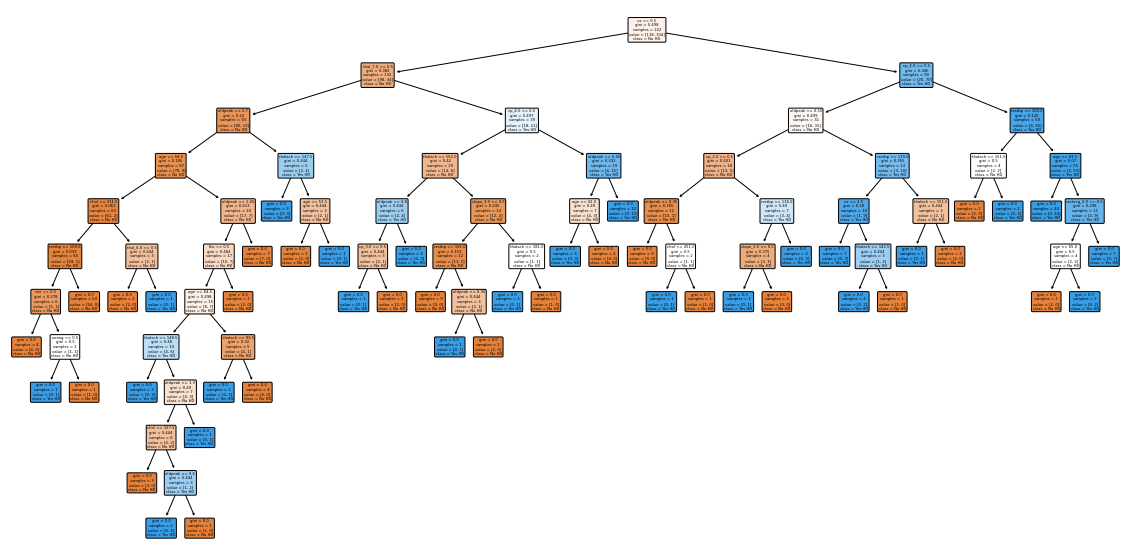

In [28]:
## NOTE: We can plot the tree and it is huge!
plt.figure(figsize = (20, 10))
# če daš ; na koncu plot_tree ti ne izpiše podatkov
plot_tree(clf_dt, filled=True, rounded=True, class_names=["No HD", "Yes HD"], feature_names=X_encoded.columns); 

OK, we've built a ***Classification tree*** for classification. Let's see how it performs on the ***Testing Dataset*** by running the ***Testing Dataset*** down the tree and drawing a ***Confusion Matrix***. 

C:\Users\lesko\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


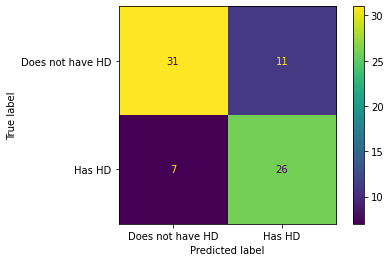

In [31]:
## plot_confusion_matrix() will run the test data down the tree and draw a confusion matrix -- zastarelo
plot_confusion_matrix(clf_dt, X_test, y_test, display_labels=["Does not have HD", "Has HD"])

In the confusion matrix, we see that of the ***31 + 11 = 42*** people that did not have ***Heart Disease***, ***31 (74 %)*** were correctly classified. And of the ***7 + 26 = 33*** people that have ***Heart Disease, 26 (79%)*** were correctly classified. Can we do better ? One thing that might be holding this ***Classification Tree*** back is that it may have ***overfit*** the training dataset. So let's prune the tree. Pruning, in theory, should solve the overfitting problem and give us better results. 

***

# Cost Complexity Pruning Part 1: Visualize alpha

***Decision Trees*** are notorious for being ***overfit*** to the ***Training Dataset***, and there are a lot of parameters, like ***max_depth*** and ***min_samples***, that are designed to reduce overfitting. However, pruning a tree with ***cost complexity pruning*** can simplify the whole process of finding a smaller tree that improves the accuracy with the ***Testing Dataset***. 

Pruning a decision tree is all about finding the right value for the pruning parameter, ***alpha***, which controls how little or how much pruning happens. 
One way to find the optimal value for ***alpha*** is to plot the accuracy of the tree as a function of different values. We'll do this for both the ***Training Dataset*** and the ***Testing Dataset***. 

First, let's extract the different values of ***alpha*** that are available for this tree and builld a pruned tree for each value for ***alpha***. ***NOTE:*** We omit the maximum value for alpha with ***ccp_alphas = ccp_alphas[:-1]*** beacuase it would prune all leaves, leaving us with only a root instead of a tree. 



In [32]:
path = clf_dt.cost_complexity_pruning_path(X_train, y_train) # determine values for alpha
ccp_alphas = path.ccp_alphas # extract different values for alpha
ccp_alphas = ccp_alphas[:-1] # exclude the maximum value for alpha

clf_dts = [] # create an array that we will put decision trees into 

## now create one decision tree per value for alpha and store it in array 
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha) 
    clf_dt.fit(X_train, y_train)
    clf_dts.append(clf_dt)

Now let's graph the accuracy of the trees using the ***Training Dataset*** and the ***Testing Dataset*** as a funtion of alpha. 

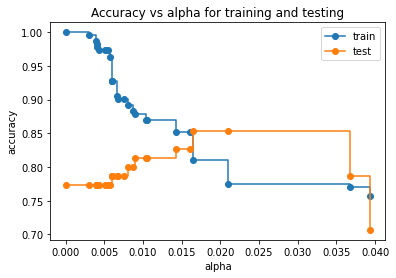

In [35]:
train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing")
ax.plot(ccp_alphas, train_scores, marker = 'o', label = 'train', drawstyle = 'steps-post')
ax.plot(ccp_alphas, test_scores, marker = 'o', label = 'test', drawstyle = 'steps-post')
ax.legend()
plt.show()

In the graph above, we see that the accuracy for the ***Testing Dataset*** hits its maximum value when ***alpha*** is about ***0.016***. After this value for ***alpha***, the accuracy of the ***Training Dataset*** drops off and that suggests we should set ***ccp_alpha=0.016***. 

***NOTE:*** When we apply ***Cost Complexity Pruning*** to a ***Classification Tree***, values for ***alpha*** go from 0 to 1, because GINI scores go from 0 to 1. In contrast, values for ***alpha*** for a ***Regression Tree*** can be much larger since the sum of squared residuals can, in theory, go from 0 to infinity. 

Since there are many ways we could have divided the original dataset into ***Training*** and ***Testing*** datasets, how do we know we used the best ***Training Dataset*** and how do we know we used the best ***Testing Dataset***? Typically, we answer this question with ***10-Fold Cross Validation***. So that's what we're going to do now, and we'll do it with the ***cross_val_score()*** function. 

***

# Cost Complexity Pruning Part 2: Cross Validation For Finding the Best Alpha

The graph we just drew suggested one value for alpha, ***0.016***, but another set of data might suggest another optimal value. 

First, let's demonstrate that different training and testing datasets result in trees with different accuracies when we set ***cpp_alpha=0.016***. We will do this by using the ***cross_val_score()*** function to generate different training and testing datasets and then train and test the tree with those datasets. 

<AxesSubplot:xlabel='tree'>

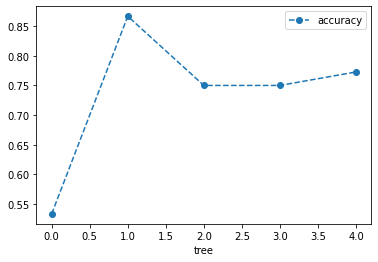

In [36]:
clf_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=0.016) # create the tree with cpp_alpha=0.016

## now use 5-fold cross validation create 5 different training and testing datasets that
## are then used to train and test the tree.
## NOTE: We use 5-fold because we don't have tons of data...
scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
df = pd.DataFrame(data={'tree': range(5), 'accuracy': scores})

df.plot(x='tree', y='accuracy', marker='o', linestyle='--')

The graph above shows that using different ***Training*** and ***Testing*** data with the same ***alpha*** resulted in different accuracies, suggesting that ***alpha*** is sensitive to the datasets. So, instead of picking a single ***Training*** dataset and single ***Testing*** dataset, let's use ***cross validation*** to find the optimal value for ***ccp_alpha***. 

<AxesSubplot:xlabel='alpha'>

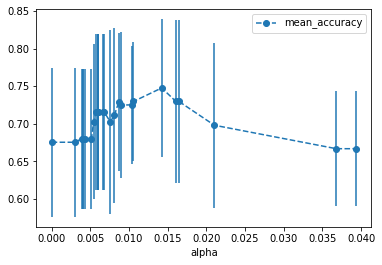

In [37]:
## create an array to store the results of each fold during cross validation 
alpha_loop_values = []

## For each candidate value for alpha, we will run 5-fold cross validation.
## Then we will store mean and standard deviation of the scores (the accuracy) for each call 
## to cross_val_score in alpha_loop_values...
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])
    
## Now we can draw a graph of the means and standard deviations of the scores
## for each candidate value for alpha
alpha_results = pd.DataFrame(alpha_loop_values, columns=['alpha', 'mean_accuracy', 'std'])

alpha_results.plot(x='alpha', y='mean_accuracy', yerr='std', marker='o', linestyle='--')

Using cross validation, we can see that, over all, instead of setting ***cpp_alpha=0.016***, we need to set it to something closer to ***0.014***. We can find the exact value with:

In [38]:
alpha_results[(alpha_results['alpha'] > 0.014) & (alpha_results['alpha'] < 0.015)]

,alpha,mean_accuracy,std
20,0.014225,0.747778,0.091395


Now let's store the ideal value for alpha so that we can use it to build the best tree.

In [39]:
ideal_cpp_alpha = alpha_results[(alpha_results['alpha'] > 0.014) & (alpha_results['alpha'] < 0.015)]['alpha']
ideal_cpp_alpha

20    0.014225
Name: alpha, dtype: float64

***NOTE:*** At this point Python thinks that ***ideal_cpp_alpha*** is a ***series***, which is a type of array. We can tell bacause when we printed ***ideal_cpp_alpha*** out, we got two bits of stuff.The first one was ***20***, which is the index in the series, the second one, ***0.014225***, is the value we want. So we can convert this from a series to a float with the following command:

In [40]:
## convert ideal_cpp_alpha from a series to a float
ideal_cpp_alpha = float(ideal_cpp_alpha)
ideal_cpp_alpha

0.014224751066856332

***

# Building, Evaluating, Drawing and Interpreting the Final Classification Tree

Now that we have the ideal value for ***alpha*** we can build the final ***Classification Tree*** by setting ***cpp_alpha=ideal_cpp_alpha***:

In [43]:
## Build and train a new decision tree, only this time use the optimal value for alpha
clf_dt_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha=ideal_cpp_alpha)
clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train)

Now let's draw another confusion matrix to see if the pruned tree does better:

C:\Users\lesko\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


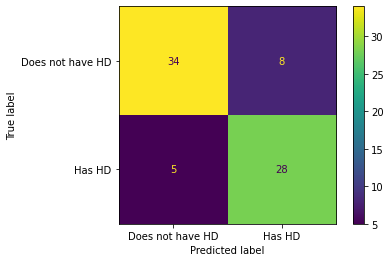

In [44]:
plot_confusion_matrix(clf_dt_pruned, X_test, y_test, display_labels=['Does not have HD', 'Has HD'])

We see that the pruned tree is better at classifying patients than the full sized tree.

Of the ***34 + 8 = 42*** people that did not have heart disease, ***34 (81 %)*** were correctly classified. This is an improvement over the full sized tree, which only correctly classified ***31 (74 %)*** of the patients without heart disease. Of the ***5 + 28 = 33*** people with heart disease, ***28 (85 %)*** were correctly classified. Again, this is an improvement over the full sized tree, which only correctly classified ***26 (79 %)*** of the patients with heart disease. 

The last thing we are going to do is draw the pruned tree.

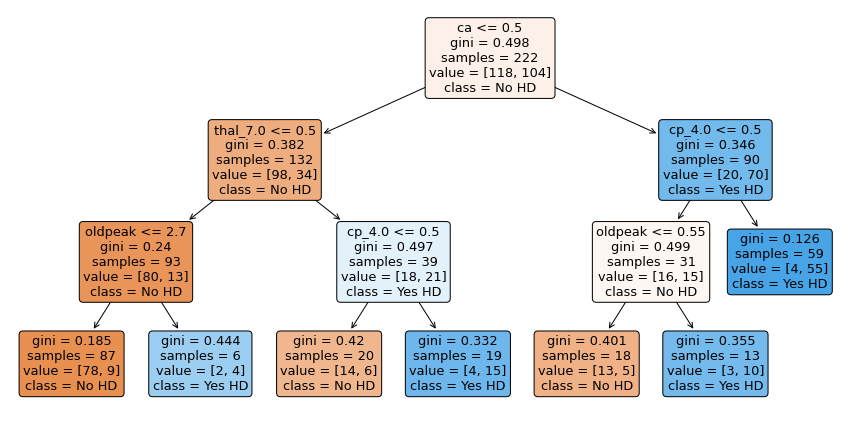

In [45]:
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt_pruned, filled = True, rounded = True, class_names = ['No HD', 'Yes HD'], feature_names = X_encoded.columns);

In each node, we have:

* The variable (column name) and the threshold for splitting the observations. For example, in the tree's root, we use ***ca*** to split the observations. All observations with ***ca <= 0.5*** go to the ***left*** and all observations with ***ca > 0.5*** go to the ***right***. 
* ***gini*** is the gini index or score for that node
* ***samples*** tell us how many samples are in the node 
* ***value*** tells us how many samples in the node are in each category. In this example, we have two categories, ***No*** and ***Yes***, referring to whether or not a patient has heart disease. The number of patients with ***No*** comes first because the categories are in alphabetical order. Thus, in the root, 118 patients have ***No*** and 104 patients have ***Yes***. 
* ***class*** tells us whichever category is represented most in the node. In the root, since 118 people have ***No*** and only 104 people have ***Yes***, class is set to ***No***.

The leaves are just like the nodes, except that they do not contain a variable and treshold for splitting the observations. 

Lastly, the nodes and leaves are colored by the ***class***. In this case ***No*** is different shades of orange-ish and ***Yes*** is different shades of blue. The darker the shade, the lower the ***gini*** score, and that tells us how much the node or leaf is skewed towards one class. 
***